In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import modules
import matplotlib.pyplot as plt
import re
import Bio
from Bio.Align import substitution_matrices

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset_utils import *
from modules.dataset import *
from modules.utils import *
from modules.models import *
from modules.lstm_utils import *

from scipy.stats import ttest_ind, describe, ttest_rel

from Bio.PDB.PDBExceptions import PDBConstructionWarning

import warnings
warnings.simplefilter('ignore', PDBConstructionWarning)


np.random.seed(0)
torch.manual_seed(0)

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "results_3"
cluster_path = data_root / "clusterRes_cdr3b_80_raw_idx_low_cov_cluster.tsv"

### Load data

In [3]:
model_dir = data_root / "raw" / "tcrpmhc"
#model_dir = data_root / "raw" / "foldx_repair"

paths = list(model_dir.glob("*"))
#paths = list()
#with open(data_root / "foldx_list.txt") as file:
#    for line in file:
#        line = line.strip()
#        paths.append(line)

join_key = [int(x.name.split("_")[0]) for x in paths]
#join_key = [int(x.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)

#
# remove swapped
#
# metadata = metadata[metadata["origin"] != "swapped"]

#loo_train_partitions, loo_test_partitions, loo_valid_partitions, unique_peptides = generate_3_loo_partitions(metadata, cluster_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = LSTMDataset(
    device=device,
    data_dir=processed_dir / "proteinsolver_embeddings_pos", 
    annotations_path=processed_dir / "proteinsolver_embeddings_pos" / "targets.pt"
)

In [4]:
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


### Get model quality proxies

In [7]:
data_rows = list()

aligner = Bio.Align.PairwiseAligner(mode="global")
aligner.substitution_matrix = substitution_matrices.load("BLOSUM50")

for pred_idx, tcrpmhc_path in zip(metadata.index, metadata["path"]):
    model_idx = Path(tcrpmhc_path).name.split("_")[0]
    tcr_path = root / "210916_TCRpMHCmodels" / "models" / f"{model_idx}_model" / "model_TCR.pdb"
    
    if tcr_path.is_file():
        data_dict = dict()
        with open(tcr_path, "r") as pdb_parse:
            for line in pdb_parse:
                template_match = re.search(r"LOOP\s+([AB]\d)\s+TEMPLATE\s+SEQUENCE:\s+(\w+)", line)
                if template_match:
                    template_loop = template_match.group(1)
                    template_seq = template_match.group(2)
                    data_dict[f"{template_loop}_template"] = template_seq

                input_match = re.search(r"LOOP\s+([AB]\d)\s+INPUT\s+SEQUENCE:\s+(\w+)", line)
                if input_match:
                    input_loop = input_match.group(1)
                    input_seq = input_match.group(2)
                    data_dict[f"{input_loop}_input"] = input_seq

        data_row = list()
        for cdr in ["A1", "A2", "A3", "B1", "B2", "B3"]:
            template_seq = data_dict[f"{cdr}_template"]
            input_seq = data_dict[f"{cdr}_input"]
            alignment = aligner.align(template_seq, input_seq)
            #data_row.append(alignment.score/list(alignment)[0].shape[1])
            data_row.append(alignment.score/max([len(template_seq), len(input_seq)]))

        super_imposer = Bio.PDB.Superimposer()

        parser = Bio.PDB.PDBParser()
        tcr_structure = parser.get_structure("tcr", tcr_path)[0]

        parser = Bio.PDB.PDBParser()
        tcrpmhc_structure = parser.get_structure("tcrpmhc", tcrpmhc_path)[0]

        tcr_atoms = list()
        tcrpmhc_atoms = list()
        for chain_id in ["A", "B"]:
            for res_tcr, res_tcrpmhc in zip(tcr_structure[chain_id], tcrpmhc_structure[chain_id]):
                for bb_atom in ["CA", "C", "N", "O"]:
                    if bb_atom in res_tcr and bb_atom in res_tcrpmhc:
                        tcr_atoms.append(res_tcr[bb_atom])
                        tcrpmhc_atoms.append(res_tcrpmhc[bb_atom])

        super_imposer.set_atoms(tcr_atoms, tcrpmhc_atoms)
        super_imposer.apply(tcrpmhc_structure.get_atoms())

        data_row.append(super_imposer.rms)

        data_rows.append(
            [pred_idx, model_idx] + data_row
        )
        if int(model_idx) in [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
            print(model_idx)

data_df = pd.DataFrame(
    data_rows,
    columns=[
    "pred_idx",
    "model_idx", 
    "cdr1a_score", 
    "cdr2a_score", 
    "cdr3a_score", 
    "cdr1b_score", 
    "cdr2b_score", 
    "cdr3b_score", 
    "tcr_rmsd"
])
data_df.to_csv(data_root / "model_quality_proxies.csv", index=False)

1
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [8]:
data_df

,pred_idx,model_idx,cdr1a_score,cdr2a_score,cdr3a_score,cdr1b_score,cdr2b_score,cdr3b_score,tcr_rmsd
0,0,1,6.777778,6.833333,3.250000,7.444444,6.166667,3.583333,1.017320
1,1,2,7.111111,5.714286,3.461538,7.222222,6.722222,2.625000,0.904631
2,2,3,2.625000,3.166667,4.727273,6.222222,4.444444,3.769231,0.941877
3,3,4,6.250000,6.600000,3.583333,7.000000,6.315789,3.800000,1.211492
4,4,5,6.500000,6.875000,3.444444,7.111111,6.722222,4.307692,0.947736
...,...,...,...,...,...,...,...,...,...
10326,10326,12961,6.777778,6.833333,3.500000,2.444444,4.400000,4.363636,1.553807
10327,10327,12962,6.875000,6.142857,4.692308,6.888889,6.611111,4.090909,1.577388
10328,10328,12966,4.555556,3.571429,6.000000,6.888889,6.611111,5.545455,1.422134
10329,10329,12968,5.333333,3.857143,4.000000,6.888889,6.611111,5.545455,1.392869


In [16]:
unique_peptides = metadata["peptide"].unique()
no_pos_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
for pep in no_pos_peptides:
    unique_peptides = np.delete(unique_peptides, np.where(unique_peptides == pep))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = Path(out_dir / "lstm_ps_no_swapped/308733536b5fc724e757c7c7fc07a7c4")
state_paths = [save_dir / f"state_{i}.pt" for i in range(len(unique_peptides))]

loo_train_partitions, loo_test_partitions, loo_valid_partitions, unique_peptides = generate_3_loo_partitions(
    metadata, 
    cluster_path,
    drop_swapped=True)

true_all = list()
pred_all = list()
index_order = list()
model_index_order = list()

for i in range(len(unique_peptides)):
    
    print("Peptide:", unique_peptides[i])

    net = QuadLSTM(
        embedding_dim=128,
        hidden_dim=128,
        num_layers=2,
        dropout=0.6,
    )
    net.load_state_dict(torch.load(state_paths[i], map_location=device))
    
    test_idx = loo_test_partitions[i]
    model_indices = metadata.iloc[test_idx]["#ID"]
    pred, true = lstm_predict(net, dataset, test_idx, device)
    true_all.append(true)
    pred_all.append(pred)
    index_order.extend(test_idx)
    model_index_order.extend(list(model_indices))

pred_flatten = torch.hstack(pred_all)
true_flatten = torch.hstack(true_all)

# loss analysis
bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
mean_loss = torch.nn.L1Loss()
bce_list = list()
mse_list = list()
abs_list = list()
with torch.no_grad():
    for p, t in zip(pred_flatten, true_flatten):
        bce_list.append(bce_loss(p, t).item())
        mse_list.append(mse_loss(p, t).item())
        abs_list.append(mean_loss(p, t).item())

data_rows = [[index_order[i], model_index_order[i], bce_list[i], mse_list[i], abs_list[i]] for i in range(len(index_order))]
data_df_full = pd.DataFrame(
    data_rows,
    columns=[
    "pred_idx",
    "model_idx",
    "bce_loss", 
    "mse_loss", 
    "abs_loss", 
])
data_df_full.to_csv(data_root / "full_data_loss.csv", index=False)

Peptide: NLVPMVATV
Peptide: SLFNTVATL
Peptide: KTWGQYWQV
Peptide: RTLNAWVKV
Peptide: KVLEYVIKV
Peptide: YLLEMLWRL
Peptide: IMDQVPFSV
Peptide: MLDLQPETT
Peptide: FLYALALLL
Peptide: SLLMWITQV
Peptide: LLFGYPVYV
Peptide: GLCTLVAML
Peptide: RMFPNAPYL
Peptide: GILGFVFTL
Peptide: KLQCVDLHV
Peptide: KVAELVHFL


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = Path(out_dir / "lstm_ps_repaired_model_subset_no_swapped/1a74acd389cb2982398cf6aa68b84998")
state_paths = [save_dir / f"state_{i}.pt" for i in range(len(unique_peptides))]
model_subset_dir = data_root / "raw" / "foldx_repair"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]

paths_subset = list(model_subset_dir.glob("*"))
path_df_subset = pd.DataFrame({'#ID': [int(x.name.split("_")[0]) for x in paths_subset]})
metadata = metadata.join(path_df_subset.set_index("#ID"), on="#ID", how="inner")

loo_train_partitions, loo_test_partitions, loo_valid_partitions, unique_peptides = generate_3_loo_partitions(
    metadata, 
    cluster_path,
    drop_swapped=True)

true_all = list()
pred_all = list()
index_order = list()
model_index_order = list()

for i in range(len(unique_peptides)):
    
    print("Peptide:", unique_peptides[i])

    net = QuadLSTM(
        embedding_dim=128,
        hidden_dim=128,
        num_layers=2,
        dropout=0.6,
    )
    net.load_state_dict(torch.load(state_paths[i], map_location=device))
    
    test_idx = loo_test_partitions[i]
    model_indices = metadata.loc[test_idx]["#ID"]
    pred, true = lstm_predict(net, dataset, test_idx, device)
    true_all.append(true)
    pred_all.append(pred)
    index_order.extend(test_idx)
    model_index_order.extend(list(model_indices))

pred_flatten = torch.hstack(pred_all)
true_flatten = torch.hstack(true_all)

# loss analysis
bce_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss()
mean_loss = torch.nn.L1Loss()
bce_list = list()
mse_list = list()
abs_list = list()
with torch.no_grad():
    for p, t in zip(pred_flatten, true_flatten):
        bce_list.append(bce_loss(p, t).item())
        mse_list.append(mse_loss(p, t).item())
        abs_list.append(mean_loss(p, t).item())

data_rows = [[index_order[i], model_index_order[i], bce_list[i], mse_list[i], abs_list[i]] for i in range(len(index_order))]
data_df_sub = pd.DataFrame(
    data_rows,
    columns=[
    "pred_idx",
    "model_idx",
    "bce_loss", 
    "mse_loss", 
    "abs_loss", 
])
data_df_sub.to_csv(data_root / "sub_data_loss.csv", index=False)

Peptide: NLVPMVATV
Peptide: SLFNTVATL
Peptide: KTWGQYWQV
Peptide: RTLNAWVKV
Peptide: KVLEYVIKV
Peptide: YLLEMLWRL
Peptide: IMDQVPFSV
Peptide: MLDLQPETT
Peptide: FLYALALLL
Peptide: SLLMWITQV
Peptide: LLFGYPVYV
Peptide: GLCTLVAML
Peptide: RMFPNAPYL
Peptide: GILGFVFTL
Peptide: KLQCVDLHV
Peptide: KVAELVHFL


In [7]:
data_df_sub = pd.read_csv(data_root / "sub_data_loss.csv")
data_df_full = pd.read_csv(data_root / "full_data_loss.csv")
data_df_qual = pd.read_csv(data_root / "model_quality_proxies.csv")

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]

In [8]:
data_df_full_merge = data_df_full.join(data_df_sub.set_index("model_idx"), on="model_idx", how="left", lsuffix="_full", rsuffix="_sub")
data_df_full_merge = data_df_full_merge.join(data_df_qual.set_index("model_idx"), on="model_idx", how="left")
data_df_full_merge = data_df_full_merge.join(metadata[["#ID", "peptide", "binder"]].set_index("#ID"), on="model_idx", how="left")

In [9]:
data_df_full_merge

,pred_idx_full,model_idx,bce_loss_full,mse_loss_full,abs_loss_full,pred_idx_sub,bce_loss_sub,mse_loss_sub,abs_loss_sub,pred_idx,cdr1a_score,cdr2a_score,cdr3a_score,cdr1b_score,cdr2b_score,cdr3b_score,tcr_rmsd,peptide,binder
0,0,1,0.124617,0.013728,0.117165,0.0,0.187642,0.029271,0.171089,0,6.777778,6.833333,3.250000,7.444444,6.166667,3.583333,1.017320,NLVPMVATV,0
1,1,2,0.136193,0.016212,0.127326,1.0,0.268073,0.055295,0.235148,1,7.111111,5.714286,3.461538,7.222222,6.722222,2.625000,0.904631,NLVPMVATV,0
2,2,3,0.103873,0.009734,0.098661,2.0,0.151405,0.019740,0.140501,2,2.625000,3.166667,4.727273,6.222222,4.444444,3.769231,0.941877,NLVPMVATV,0
3,3,4,0.093347,0.007943,0.089123,3.0,0.096060,0.008389,0.091590,3,6.250000,6.600000,3.583333,7.000000,6.315789,3.800000,1.211492,NLVPMVATV,0
4,4,5,0.206809,0.034904,0.186825,4.0,0.267883,0.055226,0.235003,4,6.500000,6.875000,3.444444,7.111111,6.722222,4.307692,0.947736,NLVPMVATV,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8504,5356,6585,0.140995,0.017294,0.131506,NaN,NaN,NaN,NaN,5356,6.777778,6.571429,4.250000,6.666667,6.894737,4.846154,0.840693,KLQCVDLHV,0
8505,9929,12488,0.950773,0.376453,0.613558,9929.0,1.471138,0.593418,0.770336,9929,6.777778,6.333333,3.363636,5.666667,7.210526,2.857143,1.172252,KLQCVDLHV,1
8506,5357,6586,0.104609,0.009865,0.099324,NaN,NaN,NaN,NaN,5357,4.700000,4.000000,3.909091,6.444444,6.611111,3.600000,1.485015,KVAELVHFL,0
8507,5358,6587,0.146077,0.018471,0.135909,NaN,NaN,NaN,NaN,5358,4.555556,3.571429,4.111111,7.000000,6.315789,4.000000,1.609096,KVAELVHFL,0


In [47]:
from scipy.stats import ttest_ind
from scipy.stats import ranksums

indices = data_df_full_merge.dropna().index
for j, col_i in enumerate([1, 2, 3]):
    for i, col_ab in enumerate(["a", "b"]): 
        subset = list(data_df_full_merge.loc[indices][f"cdr{col_i}{col_ab}_score"])
        dropped = list(data_df_full_merge.drop(indices)[f"cdr{col_i}{col_ab}_score"])
        
        print(col_ab, col_i)
        print(ranksums(subset, dropped))

df_sub = data_df_full_merge.loc[indices]
df_drop = data_df_full_merge.drop(indices)
subset = list(df_sub[df_sub["binder"] == 0]["abs_loss_full"])
dropped = list(df_drop[df_drop["binder"] == 0]["abs_loss_full"])

print("loss neg")
print(ranksums(subset, dropped))

subset = list(df_sub[df_sub["binder"] == 1]["abs_loss_full"])
dropped = list(df_drop[df_drop["binder"] == 1]["abs_loss_full"])

print("loss pos")
print(ranksums(subset, dropped))

a 1
RanksumsResult(statistic=0.24912229619024798, pvalue=0.8032661831796887)
b 1
RanksumsResult(statistic=1.2268125218261885, pvalue=0.21989306335018655)
a 2
RanksumsResult(statistic=0.11986140831386115, pvalue=0.904592935720216)
b 2
RanksumsResult(statistic=-0.4094242296862929, pvalue=0.682228361363767)
a 3
RanksumsResult(statistic=1.0881743622539328, pvalue=0.2765181405273981)
b 3
RanksumsResult(statistic=1.1329620773342015, pvalue=0.2572301790210212)
loss neg
RanksumsResult(statistic=1.8479622628042205, pvalue=0.06460780222801293)
loss pos
RanksumsResult(statistic=-0.8124750599750526, pvalue=0.4165190916544407)


In [117]:

ln = linregress(
   data_df_full_merge.loc[indices]["mse_loss_sub"], 
   data_df_full_merge.loc[indices]["cdr3b_score"]
)
ln

LinregressResult(slope=0.84704353889836, intercept=3.947821944653213, rvalue=0.28511751258640955, pvalue=5.085873024894489e-128, stderr=0.03444554839393531, intercept_stderr=0.010978173049111037)

In [183]:
from matplotlib import cm
from scipy.stats import linregress
from scipy.stats import spearmanr

my_cmap = cm.get_cmap('inferno', 10)

non_removed_idx = np.where(data_df_full_merge['abs_loss_sub'].notnull())[0]

fig, axs = plt.subplots(2,3, figsize=(10, 5))
for j, col_i in enumerate([1, 2, 3]):
    for i, col_ab in enumerate(["a", "b"]): 

        x = data_df_full_merge
        x = x[x["binder"] == 0]["abs_loss_full"]
        y = data_df_full_merge
        y = y[y["binder"] == 0][f"cdr{col_i}{col_ab}_score"]
        axs[i, j].scatter(x, y, color=my_cmap.colors[7], s=0.3)
        
        ln = spearmanr(
           x, 
           y
        )
        print(col_ab, col_i)
        print(ln)
        
        x = data_df_full_merge
        x = x[x["binder"] == 1]["abs_loss_full"]
        y = data_df_full_merge
        y = y[y["binder"] == 1][f"cdr{col_i}{col_ab}_score"]
        axs[i, j].scatter(x, y, color=my_cmap.colors[5], s=0.3)
        
        ln = spearmanr(
           x, 
           y
        )
        print(ln)
        
        ln = spearmanr(
           data_df_full_merge["abs_loss_full"], 
           data_df_full_merge[f"cdr{col_i}{col_ab}_score"]
        )
        if ln.pvalue < 0.001:
            pval = "<0.001"
        else:
            pval = f"={round(ln.pvalue, 3)}"
        axs[i, j].set_title(f"CDR{col_i}{col_ab} "+ r"$\rho$"+f"={round(ln.correlation, 3)}, p{pval}")


fig.text(0.5, -0.01, 'L1 loss', ha='center')
fig.text(-0.01, 0.5, 'BLOSUM50 alignment score', va='center', rotation='vertical')
fig.suptitle("Spearman's correlation of CDR template/query sequence similarity and L1 loss")
fig.tight_layout()
fig.subplots_adjust(top=0.87)


plt.savefig("model_qual_plot.png", dpi=300, bbox_inches = "tight")


SpearmanrResult(correlation=0.14520045380038835, pvalue=5.432591346907896e-10)
SpearmanrResult(correlation=-0.15348223816154508, pvalue=5.2319787771385626e-11)
SpearmanrResult(correlation=0.231699574468569, pvalue=1.7403889798203274e-23)
SpearmanrResult(correlation=-0.07080666794305951, pvalue=0.002577359335031132)
SpearmanrResult(correlation=-0.1568566641517884, pvalue=1.9423563128781893e-11)
SpearmanrResult(correlation=-0.12673558420048697, pvalue=6.304126715419441e-08)


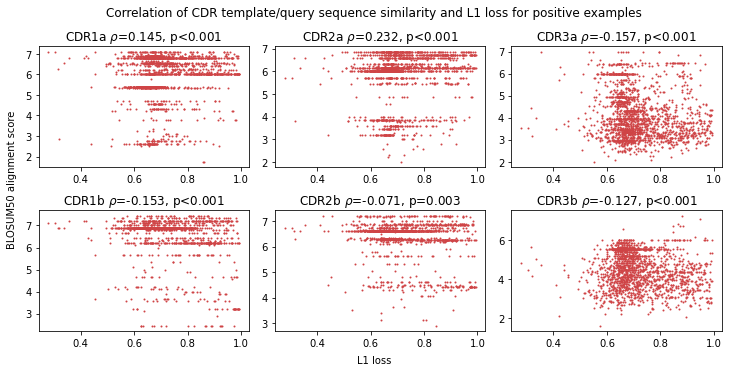

In [285]:
from matplotlib import cm
from scipy.stats import linregress
from scipy.stats import spearmanr

my_cmap = cm.get_cmap('inferno', 10)

non_removed_idx = np.where(data_df_full_merge['abs_loss_sub'].notnull())[0]

fig, axs = plt.subplots(2,3, figsize=(10, 5))
for j, col_i in enumerate([1, 2, 3]):
    for i, col_ab in enumerate(["a", "b"]): 

        #x = data_df_full_merge
        #x = x[x["binder"] == 0]["abs_loss_full"]
        #y = data_df_full_merge
        #y = y[y["binder"] == 0][f"cdr{col_i}{col_ab}_score"]
        #axs[i, j].scatter(x, y, color=my_cmap.colors[7], s=0.3)
        #
        #ln = spearmanr(
        #   x, 
        #   y
        #)
        #print(col_ab, col_i)
        #print(ln)
        
        x = data_df_full_merge
        x = x[x["binder"] == 1]["abs_loss_full"]
        y = data_df_full_merge
        y = y[y["binder"] == 1][f"cdr{col_i}{col_ab}_score"]
        axs[i, j].scatter(x, y, color=my_cmap.colors[5], s=1)
        
        ln = spearmanr(
           x, 
           y
        )
        print(ln)
        
        #ln = spearmanr(
        #   data_df_full_merge["abs_loss_full"], 
        #   data_df_full_merge[f"cdr{col_i}{col_ab}_score"]
        #)
        if ln.pvalue < 0.001:
            pval = "<0.001"
        else:
            pval = f"={round(ln.pvalue, 3)}"
        axs[i, j].set_title(f"CDR{col_i}{col_ab} "+ r"$\rho$"+f"={round(ln.correlation, 3)}, p{pval}")


fig.text(0.5, -0.01, 'L1 loss', ha='center')
fig.text(-0.01, 0.5, 'BLOSUM50 alignment score', va='center', rotation='vertical')
fig.suptitle("Correlation of CDR template/query sequence similarity and L1 loss for positive examples")
fig.tight_layout()
fig.subplots_adjust(top=0.87)


plt.savefig("model_qual_corr.png", dpi=300, bbox_inches = "tight")

In [282]:
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path,merged_chains
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVSQSNTGKLIASSQLMENTEAF
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AASEVCADYKLSASSYSLLRAAPNTEAF
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGRLGAQKLVASSQGGRRNQPQH
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVEPLYGNKLVASSSREAEAF
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...,ASGTYKYIASSQRAGRVDTQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVNSYYNQGGKLISVLQGSPYEQY
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AGNYGGSQGNLIASSIYSVNEQF
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AVGGSQGNLIASSVRSSYEQY
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...,AENGGGGADGLTASSIRSSYEQY


### Load model and make predictions

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
save_dir = Path(out_dir / "lstm_ps_foldx/6e0c63daccffcab1628283deb2d4101c")

state_paths = [save_dir / f"state_{i}.pt" for i in range(15)]
state_ensemble = [torch.load(path, map_location=device) for path in state_paths]

model_init = [
    MyLSTM(
        embedding_dim=132, 
        hidden_dim=256+4, 
        num_layers=2, 
        dropout=0.6,
    ) for _ in state_ensemble
]

for model, state in zip(model_ensemble, state_ensemble):
    model.to(device).load_state_dict(state)

model_ensemble = [model.eval() for model in model_ensemble]

In [ ]:
r = np.corrcoef(x, y)

In [25]:
data_df = data_df.join(data_df_to_join.set_index("pred_idx"), on="pred_idx", how="inner")
data_df.to_csv(data_root / "prediction_model_quality_map.csv", index=False)

AUC: 0.8333333333333334


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


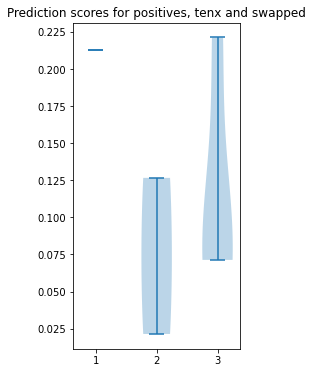

Positive stats:  DescribeResult(nobs=1, minmax=(0.2130553275346756, 0.2130553275346756), mean=0.2130553275346756, variance=nan, skewness=0.0, kurtosis=-3.0)

Tenx stats:  DescribeResult(nobs=2, minmax=(0.021427156403660774, 0.12664607167243958), mean=0.07403661403805017, variance=0.005535510065169226, skewness=0.0, kurtosis=-2.0)

Swapped stats:  DescribeResult(nobs=4, minmax=(0.07135436683893204, 0.2212609052658081), mean=0.11385968141257763, variance=0.00518656455498058, skewness=1.1158053845057232, kurtosis=-0.6992824380480762)

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=nan, pvalue=nan)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=nan, pvalue=nan)
swapped vs. tenX two-way T-test:  Ttest_indResult(statistic=0.6246499243994522, pvalue=0.5957015159731095)


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [197]:
auc = roc_auc_score(true, pred)
print("AUC:", auc)

key = np.array(metadata.iloc[test_data]["origin"])
data = np.array(np.array([pred.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
ax.violinplot([positives, tenx, swapped])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("Tenx stats: ", describe(tenx))
print()
print("Swapped stats: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))




AUC: 0.5669208146412086
MCC (t=0.1): -0.03914882991210548


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


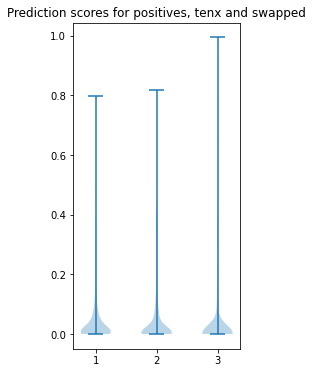

Positive stats:  DescribeResult(nobs=1810, minmax=(1.1246300346101634e-05, 0.7980820536613464), mean=0.04626288706696055, variance=0.006750820313070992, skewness=2.9882648361419917, kurtosis=10.97670678486648)

TenX stats:  DescribeResult(nobs=6699, minmax=(1.1697486115735956e-05, 0.8191697001457214), mean=0.06250205562102934, variance=0.012270134150923097, skewness=2.1712366003598875, kurtosis=4.32243443878418)

Swapped stats:  DescribeResult(nobs=1811, minmax=(1.1720622751454357e-05, 0.9942935109138489), mean=0.042100620173328676, variance=0.014543084999322777, skewness=4.242725623136483, kurtosis=21.685740465143137)

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=-6.88609214267353, pvalue=6.688086992488282e-12)
Positives > tenX one-way T-test:  Ttest_indResult(statistic=-6.88609214267353, pvalue=0.9999999999966559)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=1.213733836696145, pvalue=0.2249391575306272)
swapped vs. tenX two-way T-test:  Ttest_indR

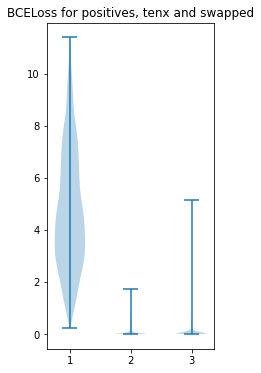

Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=88.05322715473716, pvalue=0.0)
Positives vs. swapped two-way T-test:  Ttest_indResult(statistic=87.61815345319717, pvalue=0.0)
swapped vs. tenX two-way T-test:  Ttest_indResult(statistic=-1.5210294937803572, pvalue=0.12840565249451522)


In [215]:


auc = roc_auc_score(true_flatten, pred_flatten)

threshold = 0.1
thresh_pred = torch.zeros(len(pred_flatten))
thresh_pred[pred_flatten >= threshold] = 1
mcc = matthews_corrcoef(true_flatten, thresh_pred)
print("AUC:", auc)
print(f"MCC (t={threshold}):", mcc)

# prediction analysis
flattened_valid_idx = [x for y in loo_valid for x in y]
valid_df = metadata.iloc[flattened_valid_idx]
key = np.array(valid_df["origin"])
data = np.array(np.array([pred_flatten.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
ax.violinplot([positives, tenx, swapped])
#ax.violinplot([positives, tenx])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("TenX stats: ", describe(tenx))
print()
print("Swapped stats: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
print("Positives > tenX one-way T-test: ", ttest_ind(positives, tenx, alternative="greater", equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))



data_loss = np.array(np.array([pred_loss, key]))
tenx_loss = data_loss[0][data_loss[1,] == "tenX"].astype(float)
swapped_loss = data_loss[0][data_loss[1,] == "swapped"].astype(float)
positives_loss = data_loss[0][data_loss[1,] == "positive"].astype(float)

fig, ax = plt.subplots(figsize=(3, 6))
ax.violinplot([positives_loss, tenx_loss, swapped_loss])
ax.set_title("BCELoss for positives, tenx and swapped")
plt.show()

print("Positives vs. tenX two-way T-test: ", ttest_ind(positives_loss, tenx_loss, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives_loss, swapped_loss, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped_loss, tenx_loss, equal_var=False))



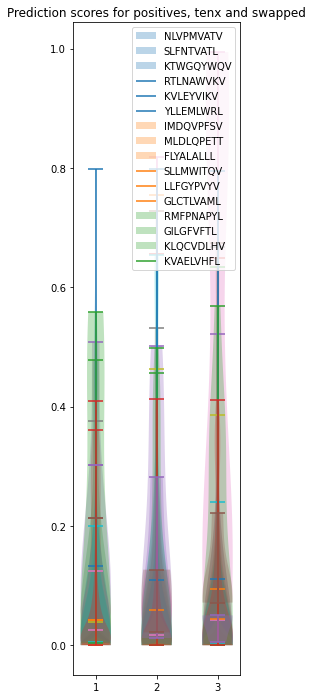

/tmp/ipykernel_160/629421353.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_loss = np.array(np.array([pred_loss, key]))


TypeError: only integer scalar arrays can be converted to a scalar index

In [217]:

#auc = roc_auc_score(true_flatten, pred_flatten)
#
#threshold = 0.1
#thresh_pred = torch.zeros(len(pred_flatten))
#thresh_pred[pred_flatten >= threshold] = 1
#mcc = matthews_corrcoef(true_flatten, thresh_pred)
#print("AUC:", auc)
#print(f"MCC (t={threshold}):", mcc)
#
# prediction analysis
fig, ax = plt.subplots(figsize=(3, 12))

for i, valid_idx in enumerate(loo_valid_partitions):
    valid_df = metadata.iloc[valid_idx]
    key = np.array(valid_df["origin"])
    data = np.array(np.array([pred_all[i].numpy(), key]))

    tenx = data[0][data[1,] == "tenX"].astype(float)
    swapped = data[0][data[1,] == "swapped"].astype(float)
    positives = data[0][data[1,] == "positive"].astype(float)

    # Create the boxplot
    ax.violinplot([positives, tenx, swapped])


ax.legend(unique_peptides)
ax.set_title("Prediction scores for positives, tenx and swapped")
plt.show()




data_loss = np.array(np.array([pred_loss, key]))
tenx_loss = data_loss[0][data_loss[1,] == "tenX"].astype(float)
swapped_loss = data_loss[0][data_loss[1,] == "swapped"].astype(float)
positives_loss = data_loss[0][data_loss[1,] == "positive"].astype(float)

fig, ax = plt.subplots(figsize=(3, 6))
ax.violinplot([positives_loss, tenx_loss, swapped_loss])
ax.set_title("BCELoss for positives, tenx and swapped")
plt.show()

print("Positives vs. tenX two-way T-test: ", ttest_ind(positives_loss, tenx_loss, equal_var=False))
print("Positives vs. swapped two-way T-test: ", ttest_ind(positives_loss, swapped_loss, equal_var=False))
print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped_loss, tenx_loss, equal_var=False))



AUC: 0.529740358707781


/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/sebastian/anaconda3/envs/ps/lib/python3.8/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


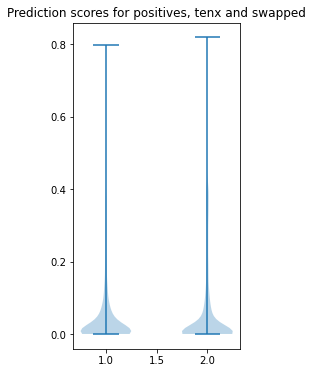

Positive stats:  DescribeResult(nobs=1810, minmax=(1.1246300346101634e-05, 0.7980820536613464), mean=0.04626288706696055, variance=0.006750820313070992, skewness=2.9882648361419917, kurtosis=10.97670678486648)

Positive tenx:  DescribeResult(nobs=6699, minmax=(1.1697486115735956e-05, 0.8191697001457214), mean=0.06250205562102934, variance=0.012270134150923097, skewness=2.1712366003598875, kurtosis=4.32243443878418)


Positives vs. tenX two-way T-test:  Ttest_indResult(statistic=-5.819377912892944, pvalue=6.120628573828395e-09)


In [177]:
auc = roc_auc_score(true_flatten, pred_flatten)
print("AUC:", auc)

flattened_valid_idx = [x for y in loo_valid for x in y]
valid_df = metadata.iloc[flattened_valid_idx]
key = np.array(valid_df["origin"])
data = np.array(np.array([pred_flatten.numpy(), key]))

tenx = data[0][data[1,] == "tenX"].astype(float)
#swapped = data[0][data[1,] == "swapped"].astype(float)
positives = data[0][data[1,] == "positive"].astype(float)

# Create an axes instance
fig, ax = plt.subplots(figsize=(3, 6))

# Create the boxplot
#ax.violinplot([positives, tenx, swapped])
ax.violinplot([positives, tenx])
ax.set_title("Prediction scores for positives, tenx and swapped")

plt.show()

print("Positive stats: ", describe(positives))
print()
print("Positive tenx: ", describe(tenx))
print()
#print("Positive swapped: ", describe(swapped))
print()
print("Positives vs. tenX two-way T-test: ", ttest_ind(positives, tenx, equal_var=False))
#print("Positives vs. swapped two-way T-test: ", ttest_ind(positives, swapped, equal_var=False))
#print("swapped vs. tenX two-way T-test: ", ttest_ind(swapped, tenx, equal_var=False))

In [194]:
from scipy import stats
rng = np.random.default_rng()
rvs1 = stats.norm.rvs(loc=5, scale=10, size=500, random_state=rng)
rvs2 = stats.norm.rvs(loc=7, scale=10, size=500, random_state=rng)
stats.ttest_ind(rvs2, rvs1, alternative="greater")

Ttest_indResult(statistic=2.8776288657908196, pvalue=0.002046087317281751)

In [188]:
np.mean(rvs2)

7.050082425769386

In [189]:
np.mean(rvs1)

4.695074304552389